# **Neural Network Estimation of Vocal Function**

Phyton code used in [1] for implementing a neural network architecture providing a mapping from aerodynamic glottal features into a set of clinically-relevant measures of vocal function. Seven input features describing the glottal airflow waveform were considered: amplitude of the unsteady glottal airflow (ACFL), maximum flow declination rate (MFDR), open quotient (OQ), speed quotient (SQ), spectral tilt measured as the log-magnitude difference between the first and second harmonics ($H_1-H_2$), fundamental frequency ($\it{f}_o$), and the sound pressure level (SPL). The output layer, in turn, involved four target vocal function measures: subglottal pressure ($P_s$), vocal fold collision pressure ($P_c$), and cricothyroid ($a_{CT}$) and thyroarytenoid ($a_{TA}$) muscle activation. The devised nonlinear mapping was trained solely with 13,000 simulated samples (DataSetModel.cvs) obtained from Monte Carlo simulations with a physiological low-order voice production model that utilizes a symmetric triangular body-cover model of the vocal folds. For more details, see [1].

[1] Emiro J. Ibarra, Jesus Parra, Gabriel A. Alzamendi, Juan P. Cortés,Víctor M. Espinoza, Daryush D. Mehta, Robert E. Hillman, and Matías Zañartu, (2021) "Estimation of subglottal pressure, vocal fold collision pressure, and intrinsic laryngeal muscle activation from neck-surface vibration using a neural network model", submitted for publication to 'Frontiers in Physiology', 2021.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset=pd.read_csv("DataSetModel.csv")
dataset

,ACFL,MFDR,OQ,SQ,f0,H1H2,spl,Ps,Pc,a_TA,a_CT
0,0.098341,79.964624,99.005682,213.977273,125.462304,13.886827,70.340915,75.542366,318.001327,0.7,0.3
1,0.532460,553.076916,99.458874,254.087306,143.414634,14.530796,90.817122,1138.378746,1531.488157,0.7,0.3
2,0.584232,613.475093,99.451754,294.360902,144.946590,14.661253,91.994977,1253.983532,1695.828870,0.7,0.3
3,0.492602,453.429468,96.143251,180.312903,121.571330,14.712990,88.332086,986.219308,1064.183805,0.8,0.3
4,0.544633,509.024995,96.508380,185.540070,123.184358,14.804854,89.915021,1096.011928,1163.309549,0.8,0.3
...,...,...,...,...,...,...,...,...,...,...,...
13610,0.033742,43.595239,99.635036,162.520158,323.076923,16.088810,68.011982,471.404923,959.515012,0.2,0.6
13611,0.033972,46.316754,99.278846,161.002093,344.531250,16.300124,67.948654,520.208479,1035.804366,0.2,0.7
13612,0.037471,54.309818,99.586777,162.834530,365.975104,15.918415,69.685682,615.130723,1159.106655,0.2,0.8
13613,0.032378,46.287677,98.996458,152.607154,365.217391,16.496537,68.133470,519.983103,1066.342100,0.2,0.8


In [3]:
#Min-max normalization function
def norm(x):
  return (x - train_stats['min']) / (train_stats['max']- train_stats['min'] )

def norm_labels(x):
  return (x - labels_train_stats['min']) / (labels_train_stats['max']- labels_train_stats['min'] )


In [4]:
#Build model

Neurons=124 

def build_model():
  model = keras.Sequential([
    layers.Dense(Neurons, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.1),
    layers.Dense(Neurons, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [5]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

In [6]:
# Data partition

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_stats = train_dataset.describe()
labels_train_stats =pd.DataFrame([train_stats.pop(x) for x in ["Ps", "Pc","a_TA", "a_CT"]])
train_stats = train_stats.transpose()

train_labels = pd.DataFrame([train_dataset.pop(x) for x in ["Ps", "Pc","a_TA", "a_CT"]]).T
test_labels = pd.DataFrame([test_dataset.pop(x) for x in ["Ps", "Pc","a_TA", "a_CT"]]).T

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_labels = norm_labels(train_labels)

In [7]:
model = build_model()
model.summary()
history = model.fit(normed_train_data, normed_train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[PrintDot()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 124)               992       
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               15500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 124)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 500       
Total params: 16,992
Trainable params: 16,992
Non-trainable params: 0
_________________________________________________________________

....................................................................................................

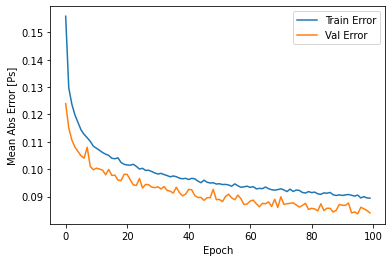

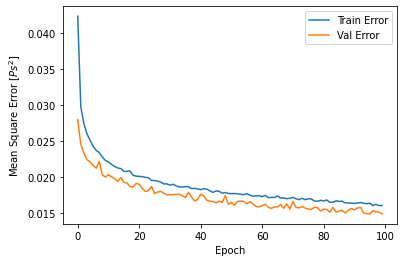

In [8]:
# Show Trained history

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Ps]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Ps^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [9]:
#Show Results

test_predictions_1 = model.predict(normed_test_data) 
test_predictions=test_predictions_1[:,0]*(labels_train_stats['max'][0]- labels_train_stats['min'][0] ) + labels_train_stats['min'][0]
RMSE=np.sqrt(np.mean(np.square(test_labels["Ps"]-test_predictions)))/98.065
MAE=np.mean(np.abs(test_labels["Ps"]-test_predictions))/98.065
MAPE=np.mean(np.abs((test_labels["Ps"]-test_predictions)/np.max(test_labels["Ps"])))*100
ME=np.mean(test_labels["Ps"]-test_predictions)
corr=np.corrcoef(test_labels["Ps"],test_predictions)[0,1]
R2=r2_score(test_labels["Ps"],test_predictions)
    
print("Testing set Ps:   MAE= {:5.2f} cmH2O, MAPE= {:5.2f} %, RMSE= {:5.2f} cmH2O, R2: {:5.2f}" .format(MAE, MAPE, RMSE, R2))


test_predictions=test_predictions_1[:,1]*(labels_train_stats['max'][1]- labels_train_stats['min'][1] ) + labels_train_stats['min'][1]
#test_predictions=test_predictions_1[:,1]*(labels_train_stats['std'][1]) + labels_train_stats['mean'][1]
RMSE=np.sqrt(np.mean(np.square(test_labels["Pc"]-test_predictions)))/98.065
MAE=np.mean(np.abs(test_labels["Pc"]-test_predictions))/98.065
MAPE=np.mean(np.abs(test_labels["Pc"]-test_predictions)/np.max(test_labels["Pc"]))*100
ME=np.mean(test_labels["Pc"]-test_predictions)
corr=np.corrcoef(test_labels["Pc"],test_predictions)[0,1]
R2=r2_score(test_labels["Pc"],test_predictions)
    
print("Testing set Pc:   MAE= {:5.2f} cmH2O, MAPE= {:5.2f} %, RMSE= {:5.2f} cmH2O, R2= {:5.2f}" .format(MAE, MAPE, RMSE, R2))

test_predictions=test_predictions_1[:,2]*(labels_train_stats['max'][2]- labels_train_stats['min'][2] ) + labels_train_stats['min'][2]
#test_predictions=test_predictions_1[:,2]*(labels_train_stats['std'][2]) + labels_train_stats['mean'][2]
RMSE=np.sqrt(np.mean(np.square(test_labels["a_TA"]-test_predictions)))
MAE=np.mean(np.abs(test_labels["a_TA"]-test_predictions))
MAPE=np.mean(np.abs(test_labels["a_TA"]-test_predictions)/np.max(test_labels["a_TA"]))*100
ME=np.mean(test_labels["a_TA"]-test_predictions)
corr=np.corrcoef(test_labels["a_TA"],test_predictions)[0,1]
R2=r2_score(test_labels["a_TA"],test_predictions)
    
print("Testing set a_TA: MAE= {:5.2f} Pa, MAPE= {:5.2f} %, RMSE= {:5.2f} cmH2O, R2= {:5.2f}" .format(MAE, MAPE, RMSE, R2))

test_predictions=test_predictions_1[:,3]*(labels_train_stats['max'][3]- labels_train_stats['min'][3] ) + labels_train_stats['min'][3]
#test_predictions=test_predictions_1[:,3]*(labels_train_stats['std'][3]) + labels_train_stats['mean'][3]
RMSE=np.sqrt(np.mean(np.square(test_labels["a_CT"]-test_predictions)))
MAE=np.mean(np.abs(test_labels["a_CT"]-test_predictions))
MAPE=np.mean(np.abs(test_labels["a_CT"]-test_predictions)/np.max(test_labels["a_CT"]))*100
ME=np.mean(test_labels["a_CT"]-test_predictions)
corr=np.corrcoef(test_labels["a_CT"],test_predictions)[0,1]
R2=r2_score(test_labels["a_CT"],test_predictions)
    
print("Testing set a_CT: MAE= {:5.2f} Pa, MAPE= {:5.2f} %, RMSE= {:5.2f} cmH2O, R2= {:5.2f}" .format(MAE, MAPE, RMSE, R2))


Testing set Ps:   MAE=  0.89 cmH2O, MAPE=  5.54 %, RMSE=  1.33 cmH2O, R2:  0.89
Testing set Pc:   MAE=  1.83 cmH2O, MAPE=  4.51 %, RMSE=  2.68 cmH2O, R2=  0.90
Testing set a_TA: MAE=  0.15 Pa, MAPE= 15.48 %, RMSE=  0.19 cmH2O, R2=  0.46
Testing set a_CT: MAE=  0.09 Pa, MAPE=  8.73 %, RMSE=  0.12 cmH2O, R2=  0.80
